# More Visualizations

From the cnns lecture, our conclusion was that we want to have more visualizations to understand what's going on in our model.

1. Saliency Maps
2. Class
3. t-SNE

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Loading the other modules I have in parent directories
import sys
PYTHONPATH="../"
sys.path.append(PYTHONPATH)
from dataProcessing import getDataLoaders
from models import FCNet, CNN_3d, layer0_12x12, layer2_12x12, layer0_3x6, count_parameters
from train import check_accuracy, train
from plottingFcts import trainingMetrics, sigBkgEff, plotROC, plotConfusion

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
loader_train, loader_val, loader_test = getDataLoaders(batch_size=16, N=20000)

## Saliency Maps

Plan: We did this in pytorch for the 2d images, so this should just involve modifying some code for 3d images! :-)

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
dtype = torch.float32

In [4]:
import tqdm 

def compute_saliency_maps(m, loader):
    """
    Compute a class saliency map using the model for showers in the DataLoader.
    Input:
    - loader: 
    - m: A pretrained model that will be used to compute the saliency map.
    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the inp
    ut
    images.
    """
    # Make sure the model is in "test" mode
    m.eval()
    
    
    l0_saliencies = []
    l1_saliencies = []
    l2_saliencies = []
    y_test = []
    
    x0 = []
    x1 = []
    x2 = []
    preds = []

    
    for l0, l1, l2, y in tqdm.tqdm(loader):
        
        l0 = l0.to(device=device, dtype=dtype)  # move to device, e.g. GPU
        l1 = l1.to(device=device, dtype=dtype)
        l2 = l2.to(device=device, dtype=dtype)
        y = y.to(device=device, dtype=torch.long)
        
        l0.requires_grad_()
        l1.requires_grad_()
        l2.requires_grad_()
        
        # forward pass through the model
        scores = m(l0,l1,l2)
        loss = F.cross_entropy(scores, y)
    
        # backward pass: compute the gradients
        loss.backward()
        
        dl0 = l0.grad
        dl1 = l1.grad
        dl2 = l2.grad
    
        l0_saliencies.append(torch.max(torch.abs(dl0),dim=1)[0])
        l1_saliencies.append(torch.max(torch.abs(dl1),dim=1)[0])
        l2_saliencies.append(torch.max(torch.abs(dl2),dim=1)[0])
        y_test.append(y.cpu().numpy())
    
        x0.append(l0.detach().numpy().squeeze())
        x1.append(l1.detach().numpy().squeeze())
        x2.append(l2.detach().numpy().squeeze())
    
        preds.append(np.argmax(scores.detach().numpy(), axis=1))
    

    # Aggregate the info, and return np arrays for plotting purposes :)
    l0_saliencies = np.concatenate(tuple(l0_saliencies),axis=0)
    l1_saliencies = np.concatenate(tuple(l1_saliencies),axis=0)
    l2_saliencies = np.concatenate(tuple(l2_saliencies),axis=0)
    y_test = np.concatenate(tuple(y_test),axis=0)
    x0 = np.concatenate(tuple(x0),axis=0)
    x1 = np.concatenate(tuple(x1),axis=0)
    x2 = np.concatenate(tuple(x2),axis=0)
    preds = np.concatenate(tuple(preds),axis=0)
        
    return l0_saliencies, l1_saliencies, l2_saliencies, y_test, x0, x1, x2, preds
        

Which model should I train this on?
- Plan: Go ahead and just use the fc net for now :)

In [5]:
cnn = CNN_3d(spatialDim=(3,6),preConvParams={'nF':32},
                 nFilters_1=32, filter_1= (3,3,3), stride_1=(1,1,1), padding_1=(1,1,1),
                 nFilters_2=16, filter_2= (3,3,2), stride_2=(2,2,2), padding_2=(1,1,1),
                 h1_dim=150, h2_dim=100)

Output size after the first conv: 32,3.0,3.0,6.0
Output size after the second conv: 16,2.0,2.0,4.0


In [6]:
cnn.modelName[:-8]

'cnn3d_3x6_C32_F333_S111_P111_C16_F332_S222_P111_fc_150_100'

In [7]:
cnn.load_state_dict(torch.load("../models/{}.pt".format(cnn.modelName[:-8])))#,
#                     map_location=lambda storage, location: 'cpu'))

In [8]:
l0_sal, l1_sal, l2_sal, y, x0, x1, x2, preds = compute_saliency_maps(cnn, loader_val)

100%|██████████| 375/375 [00:38<00:00,  9.68it/s]


**Plan:**

Now that we have some saliency maps, what can we *do* with this information?
- We can compare the validation layer images with the saliency maps (this is what we did in the HW)


In [9]:
import matplotlib.pyplot as plt

def show_saliency_maps(l0_map, l1_map, l2_map, x0_img, x1_img, x2_img, title=''):
    '''
    Compare the calorimeter image and saliency map for each layer for a shower.
    
    Inputs:
    - l0_map: saliency map for layer 0
    - l1_map:   "       "   "    "   1
    - l2_map:   "       "   "    "   2
    - x0: calorimeter image in layer 0
    - x1:       "       "   "   "    1
    - x2:       "       "   "   "    2
    - title: The title for the plot!
    '''
    
    # Step 1: Add the mean back to the img (I'll put this in later)
    
    fig = plt.figure(figsize=(6,9))
        
    # Step 3: Loop through the layers and make plots
    for i, x, l in zip(range(3), [x0_img, x1_img, x2_img], [l0_map, l1_map, l2_map]):
                
        # Validation image
        plt.subplot(3,2,i*2+1)
        plt.imshow(x, aspect='auto')
        # Turn off the axis labels
        ax = plt.gca()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.ylabel('Layer {}\n$\phi$'.format(i),fontsize=12)
        if i == 0:
            plt.title('Calorimeter Images')
        if i == 2:
            plt.xlabel('$\eta$',fontsize=12)
    
        # Saliency plot
        plt.subplot(3,2,i*2+2)
        plt.imshow(l, cmap=plt.cm.hot, aspect='auto')
        ax = plt.gca()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        if i == 0:
            plt.title('Saliency Maps')
        if i == 2:
            plt.xlabel('$\eta$',fontsize=12)
   
    plt.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.925)
    plt.show()

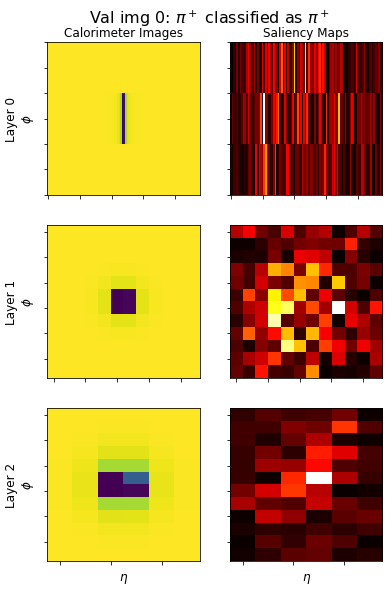

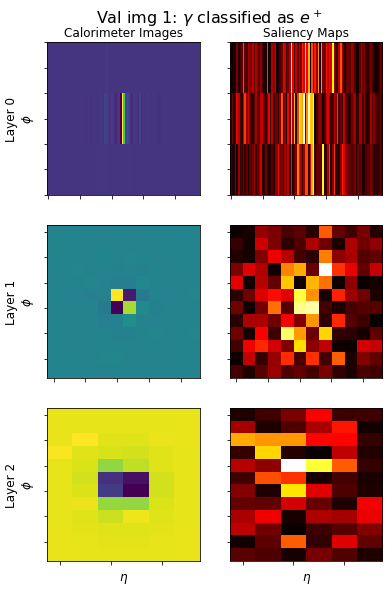

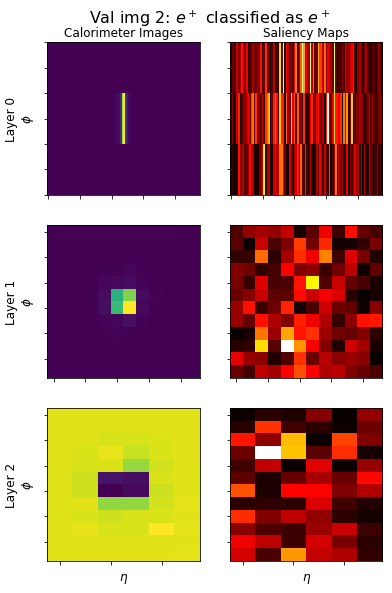

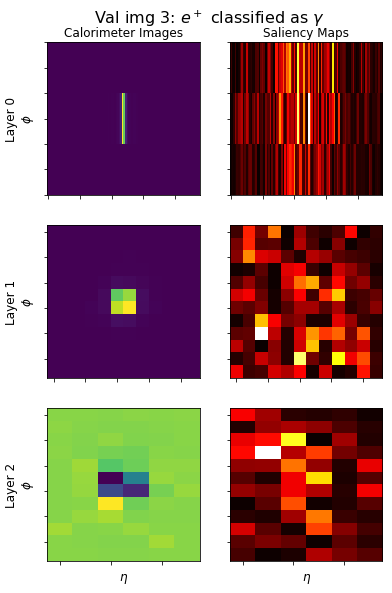

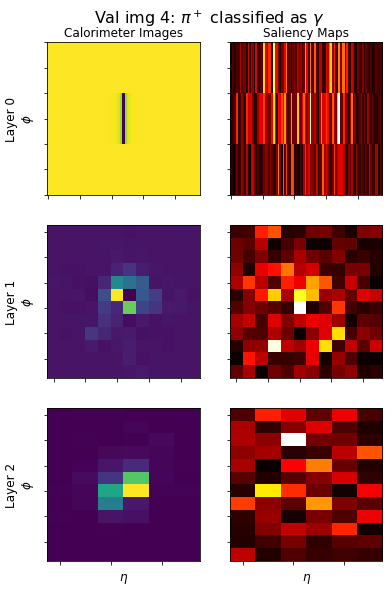

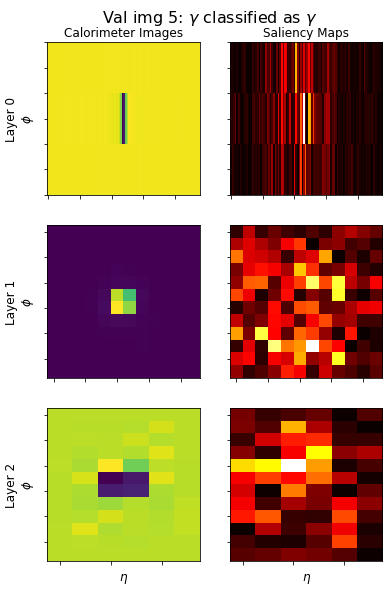

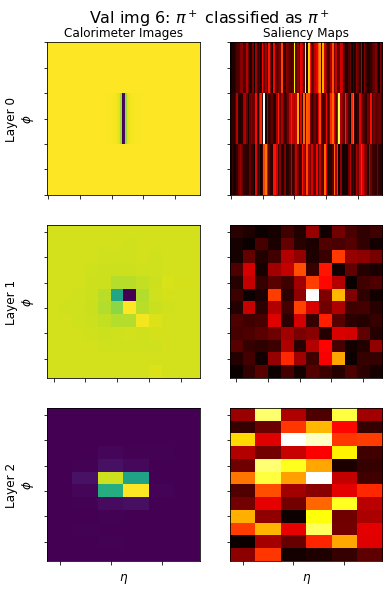

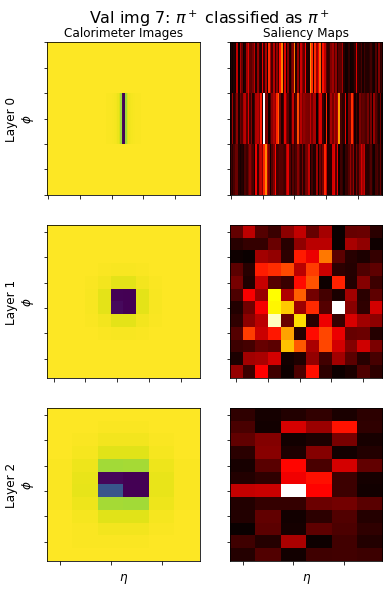

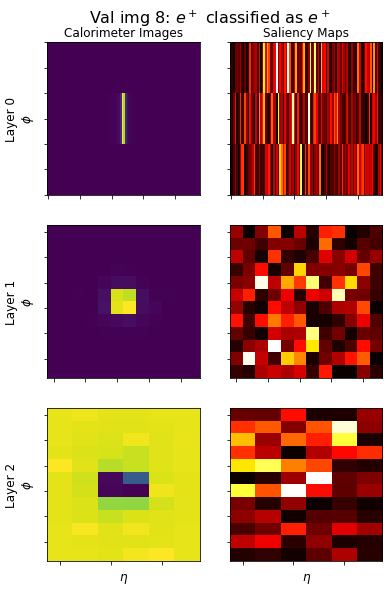

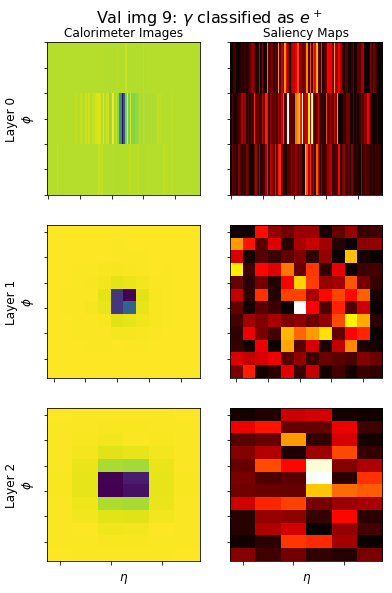

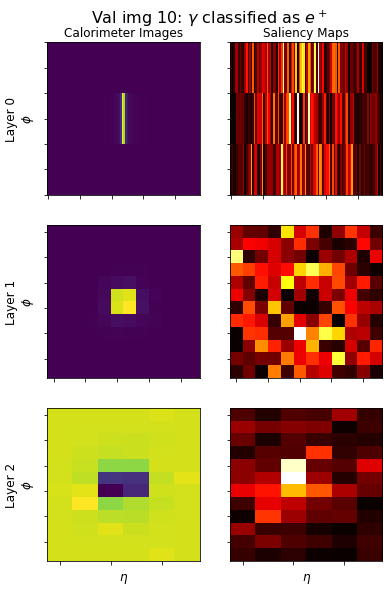

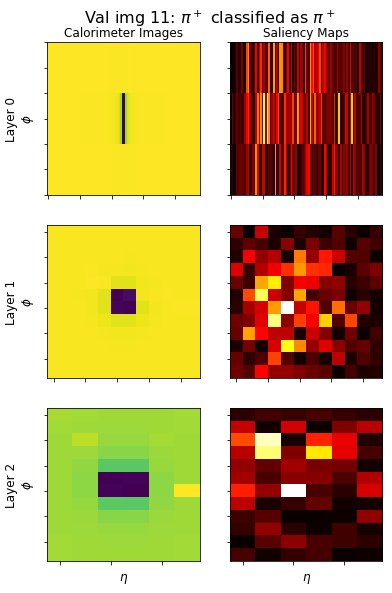

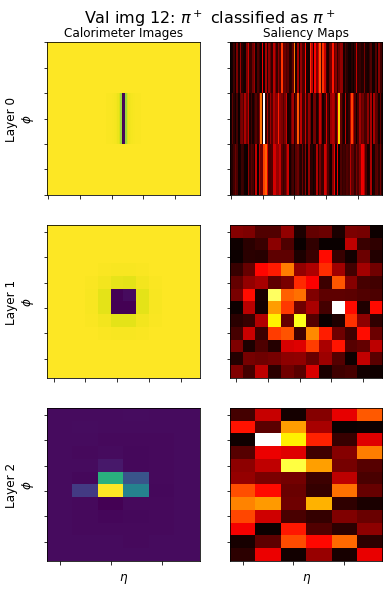

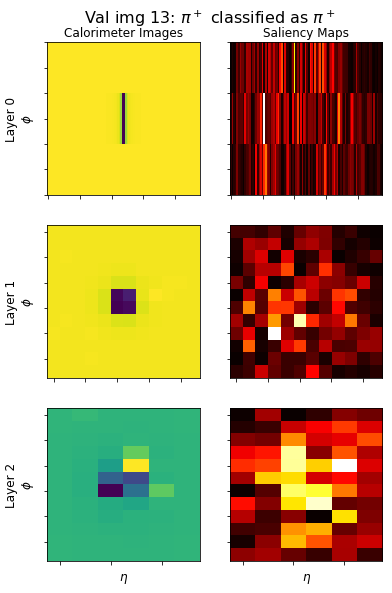

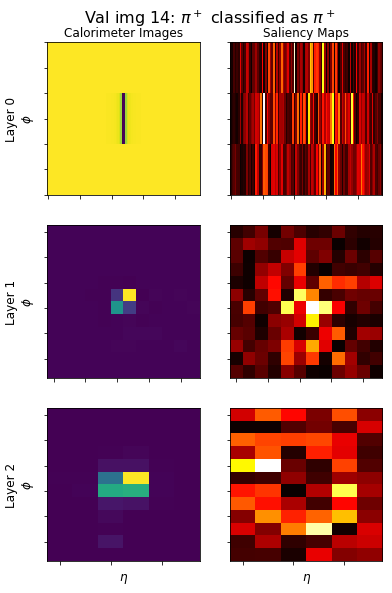

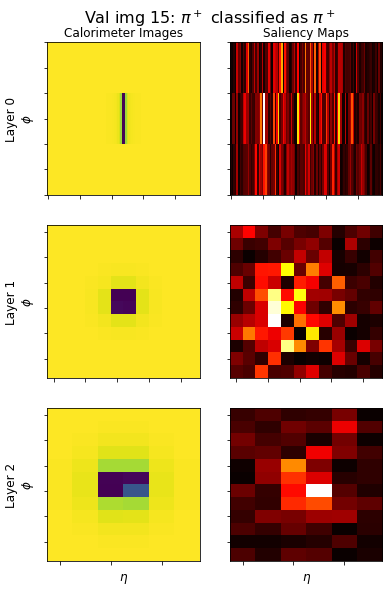

In [10]:
# Ok, let's test it out by look @ the first event
# y_test[0]
# title = ''
for i in range(100):
    pcle = { 0 : '$\gamma$', 
             1 : '$\pi^+$',
             2 : '$e^+$'}
    title = "Val img {}: {} classified as {}\n".format(i, pcle[y[i]], pcle[preds[i]])
    show_saliency_maps(l0_sal[i], l1_sal[i], l2_sal[i], x0[i], x1[i], x2[i], title)

**Next step:**
- Average the saliency plot for each block of the confusion matrix to get some aggregated information about the results from the training.
- Perhaps a good comparison would be the average image for each particle type for the inputs

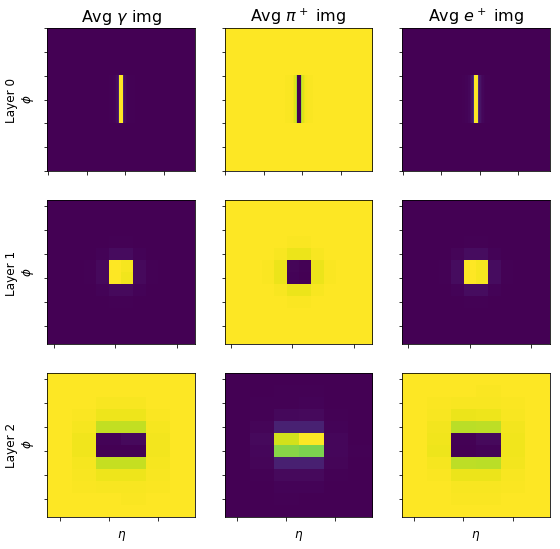

In [11]:
fig = plt.figure(figsize=(9,9))

for i in range(3):
    
    # layer 0
    plt.subplot(3,3,i+1)
    plt.imshow(x0[y==i].mean(axis=0),aspect='auto')
    
    ax = plt.gca()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    plt.title('Avg {} img'.format(pcle[i]),fontsize=16)
    
    if i == 0:
        plt.ylabel('Layer 0\n $\phi$',fontsize=12)
    
    # layer 1
    plt.subplot(3,3,4+i)
    plt.imshow(x1[y==i].mean(axis=0),aspect='auto')
    
    ax = plt.gca()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    if i == 0:
        plt.ylabel('Layer 1\n $\phi$',fontsize=12)
    
    
    # layer2
    plt.subplot(3,3,7+i)
    plt.imshow(x2[y==i].mean(axis=0),aspect='auto')
    
    ax = plt.gca()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    plt.xlabel('$\eta$',fontsize=12)
    
    if i == 0:
        plt.ylabel('Layer 2\n $\phi$',fontsize=12)

In [12]:
def plot_img_3x1(img0, img1, img2, title):

    '''
    Plot a 3x1 image of dimesnions of one of our EM showers
    '''
    
    plt.figure(figsize=(4,12))
    
    # layer 0
    plt.subplot(3,1,1)
    plt.imshow(img0,aspect='auto')

    ax = plt.gca()
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    plt.title(title, fontsize=16)
    plt.ylabel('Layer 0\n $\phi$',fontsize=12)

    # layer 1
    plt.subplot(3,1,2)
    plt.imshow(img1,aspect='auto')

    ax = plt.gca()
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    plt.ylabel('Layer 1\n $\phi$',fontsize=12)


    # layer2
    plt.subplot(3,1,3)
    plt.imshow(img2,aspect='auto')

    ax = plt.gca()
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    plt.xlabel('$\eta$',fontsize=12)

    plt.ylabel('Layer 2\n $\phi$',fontsize=12)  

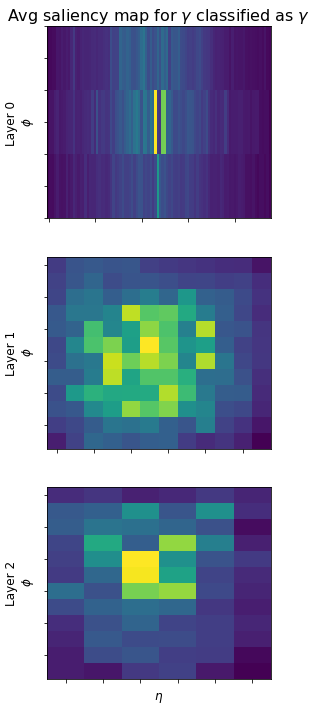

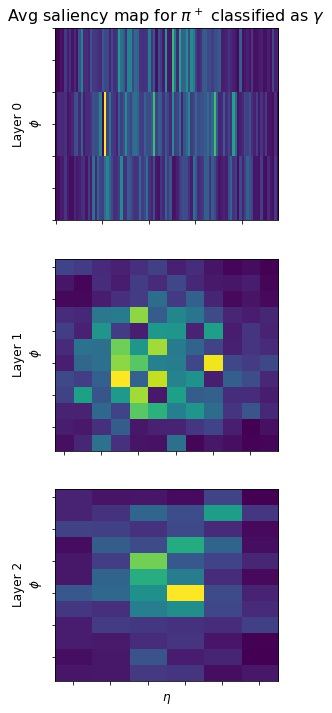

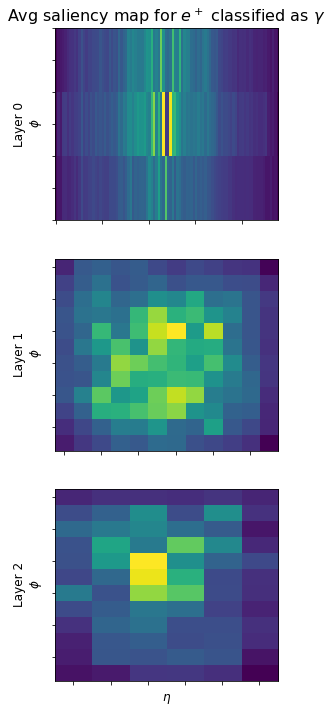

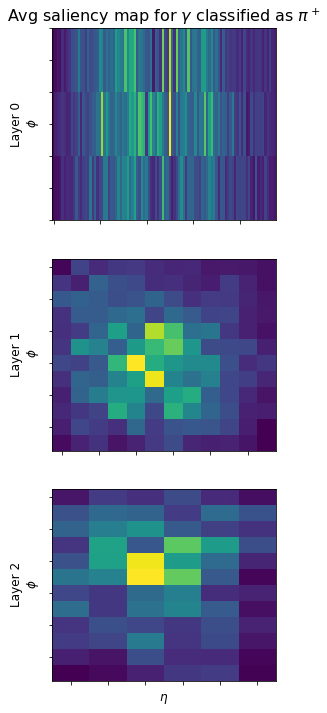

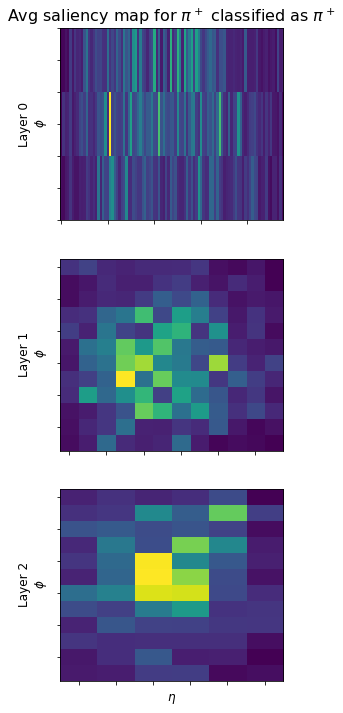

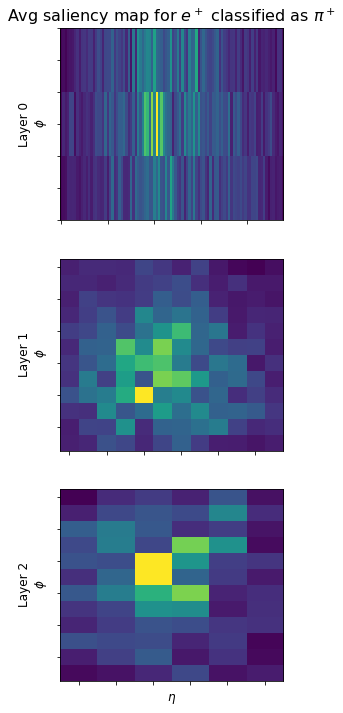

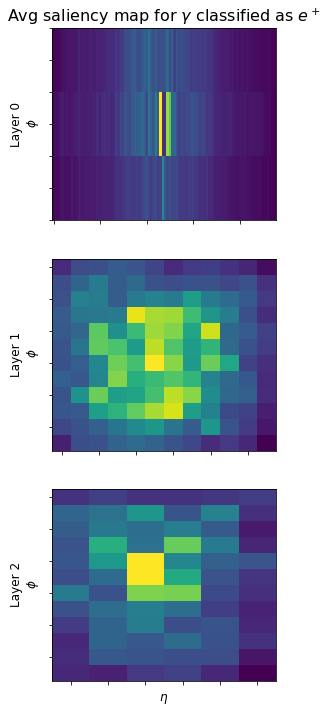

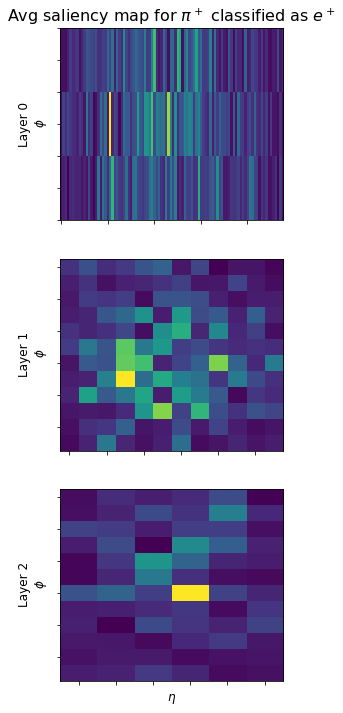

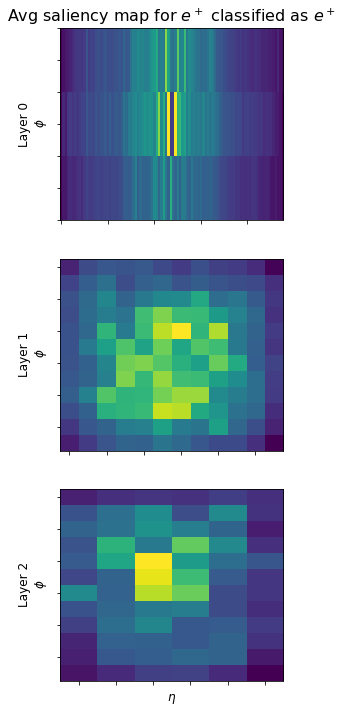

In [13]:
'''
Loop over the true and predicted particle labels and make the predictions accordingly.
'''

for yi in range(3):
    for pi in range(3):
        
        
        img0 = l0_sal[(y==yi) & (preds==pi)].mean(axis=0)
        img1 = l1_sal[(y==yi) & (preds==pi)].mean(axis=0)
        img2 = l2_sal[(y==yi) & (preds==pi)].mean(axis=0)
        title = 'Avg saliency map for {} classified as {}'.format(pcle[pi], pcle[yi])
        plot_img_3x1(img0, img1, img2, title)

plt.show()

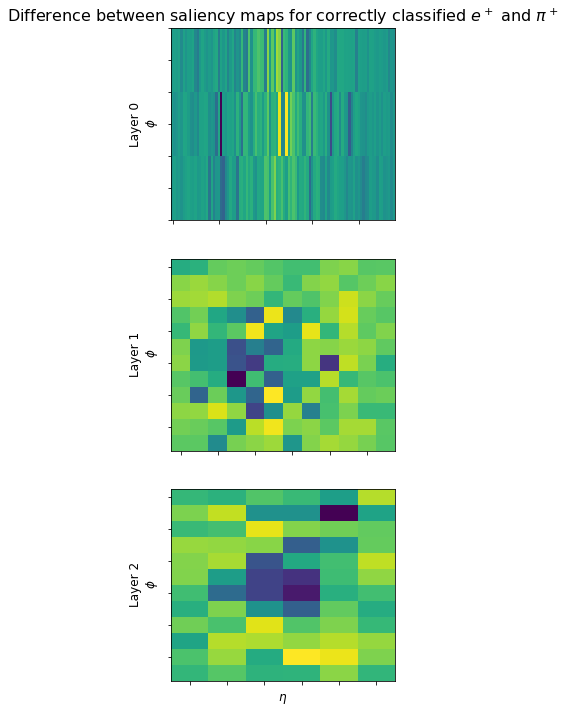

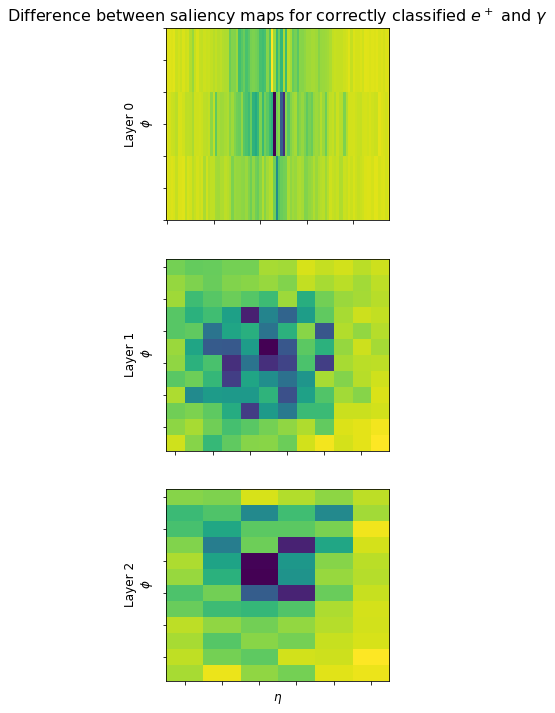

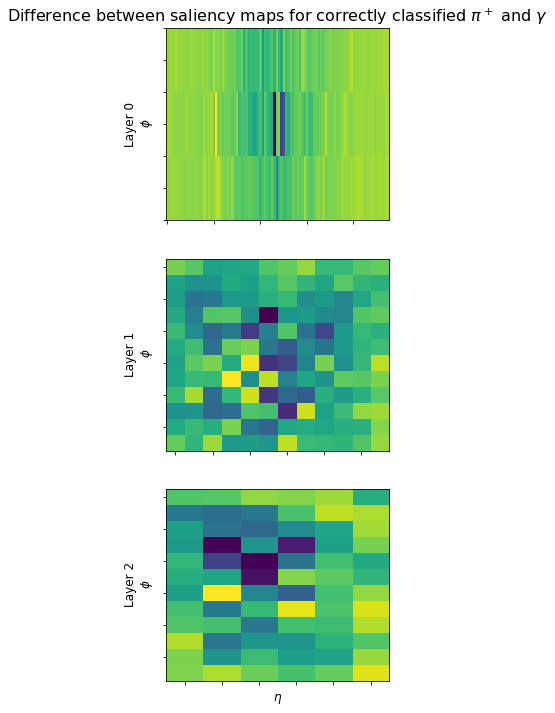

In [14]:
# Aggregate the saliency maps for the correctly classified particles
salCorrectPcle = {}

for i in range(3):
    salCorrectPcle[i] = [
        l0_sal[(y==i) & (preds==i)].mean(axis=0),
        l1_sal[(y==i) & (preds==i)].mean(axis=0),
        l2_sal[(y==i) & (preds==i)].mean(axis=0)
    ]


# electron versus pion
title='Difference between saliency maps for correctly classified $e^+$ and $\pi^+$'
plot_img_3x1(salCorrectPcle[2][0]-salCorrectPcle[1][0],
             salCorrectPcle[2][1]-salCorrectPcle[1][1],
             salCorrectPcle[2][2]-salCorrectPcle[1][2],
             title)


# electron versus photon
title='Difference between saliency maps for correctly classified $e^+$ and $\gamma$'
plot_img_3x1(salCorrectPcle[2][0]-salCorrectPcle[0][0],
             salCorrectPcle[2][1]-salCorrectPcle[0][1],
             salCorrectPcle[2][2]-salCorrectPcle[0][2],
             title)

# pion vs photon
title='Difference between saliency maps for correctly classified $\pi^+$ and $\gamma$'
plot_img_3x1(salCorrectPcle[1][0]-salCorrectPcle[0][0],
             salCorrectPcle[1][1]-salCorrectPcle[0][1],
             salCorrectPcle[1][2]-salCorrectPcle[0][2],
             title)

Agh!! I don't see any vizual difference between these images. But when I printed out the entries in the numpy arrays, the numerical values in these images are different, just not enough to show up on these images.

## Searching for highly interpretable activations

In [15]:
cnn

CNN_3d(
  (layer0_preConv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=Tru

## Class viz

In [16]:
def jitter(X, ox, oy):
    """
    Helper function to randomly jitter an image.
    Inputs
    - X: PyTorch Tensor of shape (N, C, H, W)
    - ox, oy: Integers giving number of pixels to jitter along W and H axes
    Returns: A new PyTorch Tensor of shape (N, C, H, W)
    """
    if ox != 0:
        left = X[:, :, :, :-ox]
        right = X[:, :, :, -ox:]
        X = torch.cat([right, left], dim=3)
    if oy != 0:
        top = X[:, :, :-oy]
        bottom = X[:, :, -oy:]
        X = torch.cat([bottom, top], dim=2)
    return X

In [17]:
def create_class_visualization(target_y, model, dtype, **kwargs):
    """
    Generate an image to maximize the score of target_y under a pretrained model
    .
    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    - dtype: Torch datatype to use for computations
    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to jitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    model.type(dtype)
    l2_reg = kwargs.pop('l2_reg', 1e-3)
    learning_rate = kwargs.pop('learning_rate', 25)
    num_iterations = kwargs.pop('num_iterations', 100)
    blur_every = kwargs.pop('blur_every', 10)
    max_jitter = kwargs.pop('max_jitter', 16)
    show_every = kwargs.pop('show_every', 25)
    
    # Randomly initialize the image as a PyTorch Tensor, and make it requires gradient.
    
    l0 = torch.randn(1, 1,  3, 96).mul_(1.0).type(dtype).requires_grad_()
    l1 = torch.randn(1, 1, 12, 12).mul_(1.0).type(dtype).requires_grad_()
    l2 = torch.randn(1, 1, 12,  6).mul_(1.0).type(dtype).requires_grad_()
    
    #img = torch.randn(1, 3, 224, 224).mul_(1.0).type(dtype).requires_grad_()

    for t in range(num_iterations):
        # Randomly jitter the image a bit; this gives slightly nicer results
#         ox, oy = random.randint(0, max_jitter), random.randint(0, max_jitter)
#         img.data.copy_(jitter(img.data, ox, oy))

        ########################################################################
        # TODO: Use the model to compute the gradient of the score for the #
        # class target_y with respect to the pixels of the image, and make a #
        # gradient step on the image using the learning rate. Don't forget the #
        # L2 regularization term! #
        # Be very careful about the signs of elements in your code. #
        ########################################################################
        # Compute the loss function on X
        scores = model(l0, l1, l2)
        loss = F.cross_entropy(scores, torch.LongTensor([target_y]))
        loss.backward()
        
        # Don't build a computational graph for this section
        with torch.no_grad():
            
            # Do a gradient ascent step
            dl0 = l0.grad
            dl1 = l1.grad
            dl2 = l2.grad
            
            l0.add_( learning_rate * ( dl0 - 2*l2_reg*l0))
            l1.add_( learning_rate * ( dl1 - 2*l2_reg*l1))
            l2.add_( learning_rate * ( dl2 - 2*l2_reg*l2))
            
            # Rememer in Pytorch, we need to zero out the gradients!
            l0.grad.zero_()
            l1.grad.zero_()
            l2.grad.zero_()
            
        ########################################################################
        # END OF YOUR CODE #
        ########################################################################
        # Undo the random jitter
        #img.data.copy_(jitter(img.data, -ox, -oy))
        
        # As regularizer, clamp and periodically blur the image
#         for c in range(3):
#             lo = float(-SQUEEZENET_MEAN[c] / SQUEEZENET_STD[c])
#             hi = float((1.0 - SQUEEZENET_MEAN[c]) / SQUEEZENET_STD[c])
#             img.data[:, c].clamp_(min=lo, max=hi)
#         if t % blur_every == 0:
#             blur_image(img.data, sigma=0.5)
            
        # Periodically show the image
#         if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
#             plt.imshow(deprocess(img.data.clone().cpu()))
#             class_name = class_names[target_y]
#             plt.title('%s\nIteration %d / %d' % (class_name, t + 1, num_iterations))
#             plt.gcf().set_size_inches(4, 4)
#             plt.axis('off')
#             plt.show()

    #return deprocess(img.data.cpu())
    return l0.data, l1.data, l2.data

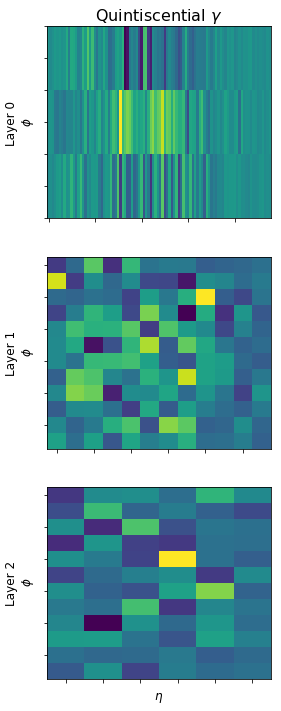

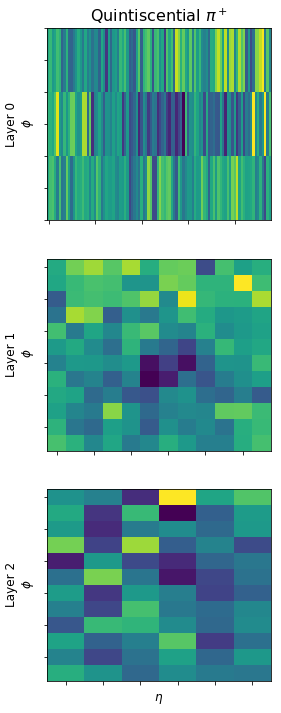

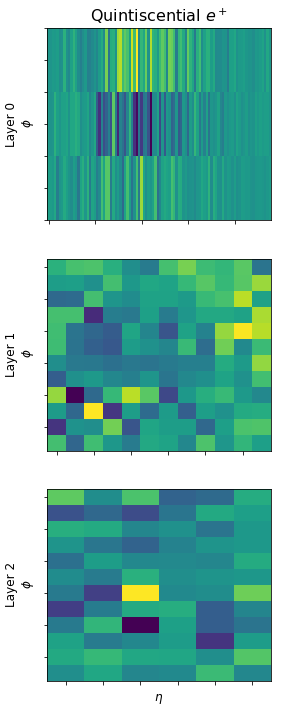

In [21]:
class_viz = {}
for i in range(3):
    img_l0, img_l1, img_l2 = create_class_visualization(i, cnn, torch.float32)
#     for img in [img_l0, img_l1, img_l2]:
#         print(img.shape)
    plot_img_3x1(img_l0.squeeze_(), img_l1.squeeze_(), img_l2.squeeze_(), 
                 'Quintiscential {}'.format(pcle[i]))

In [ ]:
class_viz[0][0] - class_viz[1][0]

In [ ]:
img_l0, img_l1, img_l2 = create_class_visualization(1, cnn, torch.float32)
#class_viz[i] = [img_l0, img_l1, img_l2]
plot_img_3x1(img_l0, img_l1, img_l2, 'Quintiscential {}'.format(pcle[i]))